# Classifying the Kepler Dataset for Exoplanets

*This notebook is a resulting project from a datascience school for astronomy in Chile, 2018.*

![sunset](./assets/Sunset.png)

## Intro:
NASA’s Kepler Space Telescope was designed to determine the frequency of Earth-sized planets orbiting Sun-like stars, but these planets are on the very edge of the mission’s detection sensitivity.

The data set is opened sourced and can be found [here](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative).

## Goal/Product:
1. **Classify unclassified planets from the kepler database with defendable metrics**
2. **Give future astro-surveys suggestions on the most important features to collect to detect planets**

## Past Work
![Research Paper Header](./assets/PaperHeader.png)
> *"We reached an 88.3% of average precision and recall (f1 score), meaning
that approximately the 88% of the times the prediction
was correct."*

## Workflow Pipeline
#### Data Preprocessing
1. Import the data and get a summary
2. Start with ~150 features, ~10,000 samples and class: FALSE_POSITIVE, CANDIDATE or POSITIVE. Note: FALSE_POSITIVE means that the object was a canidate and was found to not be a planet. So this label is essentially the same as NEGATIVE and will be called that to remove confusion.
3. Our domain experts hand select possibly relevant features, reducing our features to  about ~100.
4. Start by imputing the missing data with medians. *\[future work would be to choose a better imputation\]*
#### Feature Extraction
5. Throw all features in a random forest tree with default parameters, test with cross validation, get decent metric scores and rank features by importance.
6. Get the VIF scores for the features and remove features one-by-one that have a very high VIF/correlation score (like hand-done PCA)
7. Rerun random forest with only one feature, the most important and test with cross validation. Do this over and over for the top 40 features. Plot the metrics and look for an elbow where we stop getting better results by including more features. For us, that was around 20 features.
8. Look closely at these top 20 features, make sure that the unlabeled data follows a similar distribution to our labeled data (ideally bimodal) \[Note: at this point, we found our "greatest" feature, "Disposition Score" only existed as a good indicator for our labeled data. Go back to 6 without this feature.\]
#### Model Selection
9. Compare the performance on several classifiers with default parameters on our 20 features. Find that adaboost does the best, but random forest also does very well.
#### Model Tuning
10. [Maybe] Perform GridSearch to find the best hyper parameters for our classifier with the completeness as our optimization metric.
11. Tune the probability prediction of our model.
12. Run t-SNE to make sure that our unlabeled data is evenly distributed in the same space as our labeled data (not its own cluster).
13. Perform Gaussian clustering on the tSNE plot to get the labeled data most similar to the unlabeled data.
#### Final Model Performance
13. Plot probability distributions against "disposition score"
14. Run classifier on hand picked testing set (labeled data most like our candidate data)

# Code

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import numpy as np
import collections
import matplotlib.pyplot as plt
from scipy import stats

import sklearn
from sklearn import metrics
from sklearn import decomposition
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Data Preprocessing
##### Import the data and get a summary

In [3]:
raw = pd.read_csv('KeplerData.csv')
target_name = 'Exoplanet Archive Disposition'
feature_names = raw.columns[4:]
raw = raw[[target_name, *feature_names]]
print("Size of our Data")
print("Samples: {}, Features: {}".format(raw.shape[0], raw.shape[1]-1))

Size of our Data
Samples: 9564, Features: 98


##### Impute the missing data with medians.

In [4]:
# IMPUTE
# Fill Disposition Score with 0.5
raw_withoutna = raw.copy()
raw_withoutna['Disposition Score'].fillna(0, inplace=True)
# Fill flags with 0
flag_names = ['Not Transit-Like False Positive Flag', 'Stellar Eclipse False Positive Flag', 'Centroid Offset False Positive Flag', 'Ephermeris Match Indicates Contamination False Positive Flag']
raw_withoutna[flag_names].fillna(0, inplace=True)
# Fill all other nulls with median
raw_withoutna.fillna(raw_withoutna.median(), inplace=True)
# remove canidates for prediction (2244 rows)
data = raw_withoutna[raw_withoutna[target_name] != 'CANDIDATE']
# remove column 'Disposition Score' becuase it is not really a feature
data = data.drop(['Disposition Score'], axis=1)
feature_names = list(set(feature_names) - set(['Disposition Score']))

##### Take a quick look at our data

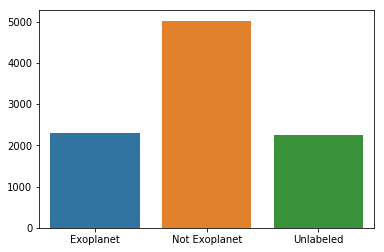

In [5]:
c = collections.Counter(raw[target_name])
g = sns.barplot(['Exoplanet', 'Not Exoplanet', 'Unlabeled'], list(c.values()))

### Feature Extraction

##### Fit a preliminary classifier to our data. Does it seem to understand our data?

In [6]:
scoring = ['accuracy', 'precision', 'recall']
clf = RandomForestClassifier(random_state=0)
scores = cross_validate(clf, data[feature_names],
                        data[target_name]=='CONFIRMED', scoring=scoring,
                        cv=5, return_train_score=True)
print("Accuracy:\t\t", np.mean(scores['test_accuracy']))
print("Completeness:\t\t", np.mean(scores['test_recall']))
print("Contamination:\t\t", 1 - np.mean(scores['test_precision']))

Accuracy:		 0.97363022962563
Completeness:		 0.9298882258217296
Contamination:		 0.014164493359786645


##### Sort features by feature importance

In [7]:
clf.fit(data[feature_names], data[target_name])
values = list(zip(data[feature_names], clf.feature_importances_))
sortd = sorted(values, reverse = True, key= lambda x: x[1])
important_names = [s[0] for s in sortd]
sortd[:10]

[('PRF Delta Theta SQ (KIC) [arcsec]', 0.08472692388516276),
 ('Not Transit-Like False Positive Flag', 0.07938343531796094),
 ('Planetary Radius [Earth radii].1', 0.06210535255768148),
 ('Stellar Eclipse False Positive Flag', 0.05909828367960166),
 ('Stellar Metallicity Upper Uncertainty [dex]', 0.05572051792300262),
 ('Stellar Metallicity Lower Uncertainty [dex]', 0.05487290647688137),
 ('Stellar Effective Temperature Upper Uncertainty [K]', 0.03813731101504158),
 ('PRF Delta Theta SQ (OOT) [arcsec]', 0.037844140165104644),
 ('Centroid Offset False Positive Flag', 0.035415793389987134),
 ('Number of Planets', 0.03485576314653982)]

In [8]:
# g = data[[*top_names, target_name]].groupby(target_name).hist()

##### Remove important features that have high correlation

In [9]:
# X = data[important_names]
# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# print("Maximum VIF before removal:", round(vif['VIF Factor'].max()))

highVIFS = [
    'Planetary Radius Lower Unc. [Earth radii]', 
    'Planetary Radius [Earth radii]',
    'Stellar Effective Temperature Upper Uncertainty [K]',
    'Transit Duration Upper Uncertainty [hrs]',
    'Stellar Metallicity Upper Uncertainty [dex]',
]
important_names = list(set(important_names[:20]) - set(highVIFS))
X = data[important_names]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print("Maximum VIF after removal:", round(vif['VIF Factor'].max()))

Maximum VIF after removal: 14.0


##### Iteratively run random forest using only the top n most important features

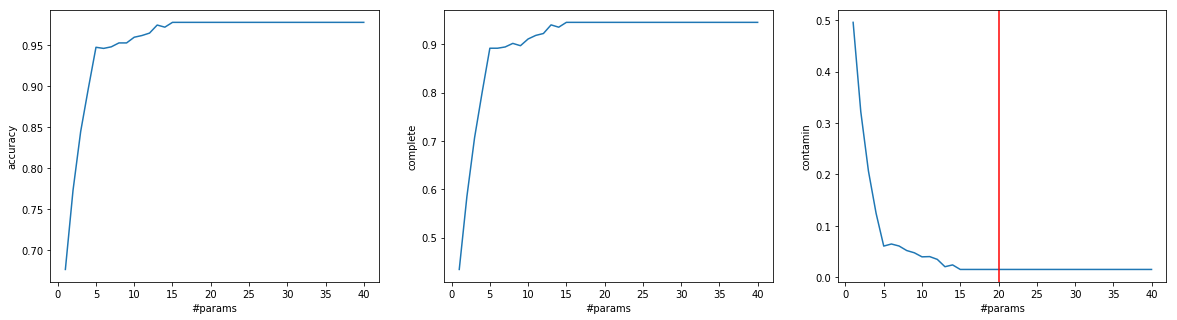

In [10]:
test = []
for i in range(1, 41):
    imp = important_names[:i]
    clf = RandomForestClassifier(random_state=0)
    clf.fit(data[imp], data[target_name])
    scoring = ['accuracy', 'precision', 'recall']
    scores = cross_validate(clf, data[imp],
                            data[target_name]=='CONFIRMED', scoring=scoring,
                            cv=5, return_train_score=True)
    test.append((i, np.mean(scores['test_accuracy']), np.mean(scores['test_recall']), 1 - np.mean(scores['test_precision'])))

df_test = pd.DataFrame(test, columns=['#params', 'accuracy', 'complete', 'contamin'])
fig, axs = plt.subplots(ncols=3, figsize=(20,5))
sns.lineplot(x="#params", y="accuracy", data=df_test, ax=axs[0])
sns.lineplot(x="#params", y="complete", data=df_test, ax=axs[1])
sns.lineplot(x="#params", y="contamin", data=df_test, ax=axs[2])
plt.axvline(x=20, color='red')

In [11]:
# we see that we get great results after just 20 features
top_names = important_names[:20]

### Model Selection

##### Compare the performance of several classifiers

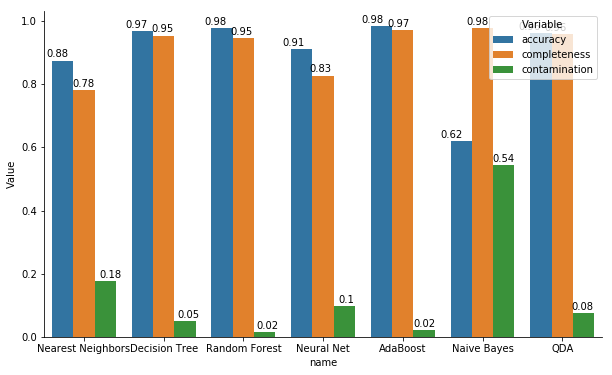

In [12]:
names = ["Nearest Neighbors",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(n_neighbors=10),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    MLPClassifier(random_state=0),
    AdaBoostClassifier(n_estimators=100, random_state=0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scoring = ['accuracy', 'precision', 'recall']
scores_list = []
# iterate over classifiers
for name, clf in zip(names, classifiers):
    scores = cross_validate(clf, data[top_names],
                            data[target_name]=='CONFIRMED', scoring=scoring,
                            cv=5, return_train_score=True)
    scores_list.append([name, np.mean(scores['test_accuracy']), np.mean(scores['test_recall']), 1 - np.mean(scores['test_precision'])])

scores_df = pd.DataFrame(scores_list, columns=['name', 'accuracy', 'completeness', 'contamination'])
fig, ax1 = plt.subplots(figsize=(10, 6))
tidy = (
    scores_df.set_index('name')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)
g = sns.barplot(x='name', y='Value', hue='Variable', data=tidy, ax=ax1)
for index, row in tidy.iterrows():
    g.text((row.name-1)/3.04,row.Value + .01, round(row.Value,2), color='black', ha="center")
sns.despine(fig)

### Model Tuning

##### Run Grid Search on Random Forest, trying to optimize for completeness

In [13]:
clf = RandomForestClassifier(n_jobs=-1, random_state=0)

# This takes a while to run with more values,
# I found these as the best parameteres.
param_grid = {
    'n_estimators' : [300],
    'max_depth': [5],
    'max_features': [5]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

X_train, X_test, y_train, y_test = \
    train_test_split(data[top_names], data[target_name] == 'CONFIRMED', random_state=0)

skf = StratifiedKFold(n_splits=4)
grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit='recall_score',
                       cv=skf, return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)

# make the predictions
y_pred = grid_search.predict(X_test)

print('Best params for completeness:', grid_search.best_params_)
results = pd.DataFrame(grid_search.cv_results_)
bestResults = results[results.params == grid_search.best_params_]
completeness = float(bestResults['mean_test_recall_score'])
print('Completion: {:.2f}'.format(completeness))
# confusion matrix on the test data.
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])

Best params for completeness: {'max_depth': 5, 'max_features': 5, 'n_estimators': 300}
Completion: 0.94


##### Calibrate the probability prediction of our model.

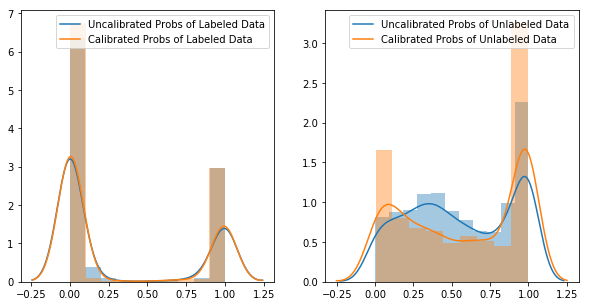

In [14]:
clf = RandomForestClassifier(random_state=0)
X_labeled, y = data[top_names], data[target_name]
clf.fit(X_labeled, y)
X_candidates = raw_withoutna[top_names][raw[target_name] == 'CANDIDATE']
calibrated = CalibratedClassifierCV(clf, method='isotonic')
calibrated.fit(X_labeled, y)

probs_labeled = [x[0] for x in clf.predict_proba(X_labeled)]
probs_calib_labeled = [x[0] for x in calibrated.predict_proba(X_labeled)]
probs_unlabeled = [x[0] for x in clf.predict_proba(X_candidates)]
probs_calib_unlabeled = [x[0] for x in calibrated.predict_proba(X_candidates)]

fig, axs = plt.subplots(ncols=2, figsize=(10,5))
sns.distplot(probs_labeled, ax=axs[0], kde_kws={"label": "Uncalibrated Probs of Labeled Data"})
sns.distplot(probs_calib_labeled, ax=axs[0], kde_kws={"label": "Calibrated Probs of Labeled Data"})
sns.distplot(probs_unlabeled, ax=axs[1], kde_kws={"label": "Uncalibrated Probs of Unlabeled Data"})
sns.distplot(probs_calib_unlabeled, ax=axs[1], kde_kws={"label": "Calibrated Probs of Unlabeled Data"})

### Access final model performance

##### Plot probability distributions against "Disposition Score"

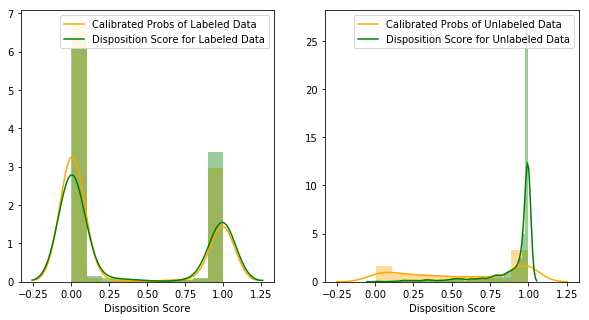

In [15]:
clf = RandomForestClassifier(random_state=0)
X_labeled, y = data[top_names], data[target_name]
clf.fit(X_labeled, y)
X_candidates = raw_withoutna[top_names][raw[target_name] == 'CANDIDATE']
calibrated = CalibratedClassifierCV(clf, method='isotonic')
calibrated.fit(X_labeled, y)

probs_labeled = [x[0] for x in clf.predict_proba(X_labeled)]
probs_calib_labeled = [x[0] for x in calibrated.predict_proba(X_labeled)]
probs_unlabeled = [x[0] for x in clf.predict_proba(X_candidates)]
probs_calib_unlabeled = [x[0] for x in calibrated.predict_proba(X_candidates)]

fig, axs = plt.subplots(ncols=2, figsize=(10,5))
sns.distplot(probs_calib_labeled, ax=axs[0], kde_kws={"label": "Calibrated Probs of Labeled Data"}, color='orange')
sns.distplot(raw['Disposition Score'][raw[target_name] != 'CANDIDATE'].dropna(), ax=axs[0], kde_kws={"label": "Disposition Score for Labeled Data"}, color='green')
sns.distplot(probs_calib_unlabeled, ax=axs[1], kde_kws={"label": "Calibrated Probs of Unlabeled Data"}, color='orange')
sns.distplot(raw['Disposition Score'][raw[target_name] == 'CANDIDATE'].dropna(), ax=axs[1], kde_kws={"label": "Disposition Score for Unlabeled Data"}, color='green')

##### Make predictions on our candidates

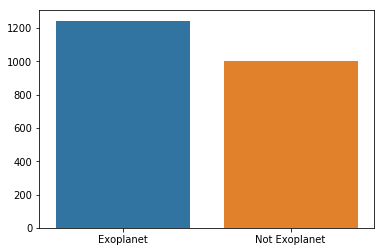

In [16]:
c = collections.Counter(list(calibrated.predict(X_candidates[top_names])))
g = sns.barplot(['Exoplanet', 'Not Exoplanet'], list(c.values()))

##### Run classifier on hand picked testing set (most like our candidate data)
(Run t-SNE to make sure that our unlabeled data is evenly distributed in the same space as our labeled data (not its own cluster))

In [17]:
df_candidate_mask = pd.read_csv('candidateLikeData.csv')
mask = list(df_candidate_mask['Candidate Classifier Flag'] == 1)
df_candidate = data[mask]

In [18]:
data['Candidate-like Data Flag'] = df_candidate_mask['Candidate Classifier Flag']
(_, train), (_, test) = data.groupby(['Candidate-like Data Flag'])
print('Training samples:', len(train))
print('Testing samples:', len(test))

Training samples: 3405
Testing samples: 2188


In [19]:
# test how well a random forest does on labeled data
# that is most like our unlabeled/candidate data
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
X, y = train[top_names], train[target_name]
clf.fit(X, y)
y_true = test[target_name]
y_pred = clf.predict(test[top_names])
accuracy = accuracy_score(y_true=='CONFIRMED', y_pred=='CONFIRMED')
complete = recall_score(y_true=='CONFIRMED', y_pred=='CONFIRMED')
contamin = 1 - precision_score(y_true=='CONFIRMED', y_pred=='CONFIRMED')
print("Results for the candidate-like testing data:")
print("Accuracy:\t\t{:3f}".format(accuracy))
print("Completeness:\t\t{:3f}".format(complete))
print("Contamination:\t\t{:3f}".format(contamin))

Results for the candidate-like testing data:
Accuracy:		0.983547
Completeness:		0.980088
Contamination:		0.019912


# Thank you!